<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Error Analaysis Part 2: Misclassification Analysis</h1> 
<h2 style="text-align: center;" markdown="3">Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  

[Misclassification Confidence](#confidence)

[Load Expenditure Data](#loadexp)

[Load FP/FN](#loadfpfn)

[Plot FP and FN](#plotfpfn)

[Plot Consumption Rate](#consrate)

[Jaccard Similarity](#jsim)

[Summary](#summary)



# Misclassification Analysis Introduction <a class="anchor" id="introduction"></a>

In this notebook, we use the error `DataFrame`s generated in the previous notebook (`18.1a-error-analysis.ipynb`) to examine various perperties of the misclassifications. First, we'll look at the concentration of false positives and false negatives around the poverty line. Next, we'll visualize the model confidences for the misclassifications. Then we'll consider aggregate consumption patterns present in the dataset to see if false positive and false negative misclassifications are more similar to the poor or non-poor class.

First, we load the standard libraries as usual:

In [1]:
%matplotlib inline

import os
from pathlib import Path
import sys
import json

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 450)

from pandas.io.stata import StataReader
from tqdm import tqdm

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set(style="white", context="paper")
plt.rc("axes.spines", top=False, right=False, left=False, bottom=False)

sys.path.append(os.path.join(os.pardir, 'src'))
from data import load_data

from sklearn.model_selection import train_test_split

ERRORS_DIR = Path('..', 'data', 'processed', 'idn', 'errors')

# Load Expenditure Data <a class="anchor" id="loadexp"></a>

To measure distances from the poverty line, we'll need to know a household's actual expenditure (not just whether or not it's anove or below the poverty line). To get this information, we'll have to go back to the raw data.

## Load original household data

Below we'll re-define the utility function used to load the original stata files and convert them to properly formatted Pandas DataFrames. The function will be used to load the class data (poor vs. non-poor) as well as the expenditure data. We can then verify the consistency between the two sources before proceeeding.

In [2]:
# utility for loading original stata files
def load_stata_file(filepath, 
                    index_cols, 
                    update_education=False, 
                    drop_minornans=False, 
                    drop_unlabeled=False):
    """ Load data and metadata from Stata file"""
    data = pd.read_stata(filepath, convert_categoricals=False).set_index(index_cols)

    with StataReader(filepath) as reader:
        reader.value_labels()
            
        mapping = {col: reader.value_label_dict[t] for col, t in 
                   zip(reader.varlist, reader.lbllist)
                   if t in reader.value_label_dict}
        
        # manually update some specific columns
        # in the Malawi dataset
        if update_education and 'ind_educ09' in mapping:
            mapping['ind_educ09'][13] = "Primary - " + mapping['ind_educ09'][13]
            mapping['ind_educ09'][14] = "Primary - " + mapping['ind_educ09'][14]
            
            mapping['ind_educ09'][23] = "Secondary - " + mapping['ind_educ09'][23]
            mapping['ind_educ09'][24] = "Secondary - " + mapping['ind_educ09'][24]
        
        data.replace(mapping, inplace=True)
        
        # convert the categorical variables into
        # the category type
        for c in data.columns:
            if c in mapping:
                data[c] = data[c].astype('category')
                        
        # drop records with only a few nans
        if drop_minornans: 
            nan_counts = (data.applymap(pd.isnull)
                          .sum(axis=0)
                          .sort_values(ascending=False))
            nan_cols = nan_counts[(nan_counts > 0) & (nan_counts < 10)].index.values
            data = data.dropna(subset=nan_cols)
        # drop unlabeled categorical values
        def find_unlabeled(x):
            if x.name in mapping.keys():
                return [val if (val in mapping[x.name].values() or pd.isnull(val)) 
                        else 'UNLABELED' for val in x]
            else:
                return x
            
        data = data.apply(find_unlabeled)
        data = data[~data.applymap(lambda x: x == "UNLABELED").any(axis=1)]
        
        # read the actual questions that were asked for reference
        questions = reader.variable_labels()
        
        return data, questions

Select just the columns we need for this verification.

  - household size
  - household weight
  - create boolean poor/non-poor based on string column `poor`

In [3]:
idn_hhold, idn_hhold_questions = load_stata_file(load_data.IDN_HOUSEHOLD, 
                                                 ['hid'], 
                                                 drop_minornans=True, 
                                                 drop_unlabeled=True)

# Create boolean poor/non-poor and grab just the columns we need
idn_hhold_pov = idn_hhold.assign(original_poor_bool=lambda x: x.poor == 'Poor')
idn_hhold_pov = idn_hhold_pov[['original_poor_bool', 'wta_pop', 'der_hhsize']]

idn_hhold_pov.head()

,original_poor_bool,wta_pop,der_hhsize
hid,,,
1101010200360401,False,1051.920532,6
1101010200360402,False,1221.200439,4
1101010200360403,False,361.736084,3
1101010200360404,False,141.106323,2
1101010200360405,False,131.471115,2


In [4]:
# ~10% poor, which is correct
idn_hhold_pov.original_poor_bool.value_counts()

False    64454
True      6389
Name: original_poor_bool, dtype: int64

## Load household expenditure data

Load expenditures and create the variables that we need for analysis. Join original data and that poor/non-poor boolean on the `hid` across both datasets.

  - `per_capita_expenditure` - calculated as total expenditure divided by household size
  - `expenditure_poor` - whether the per capita expenditure is above or below the poverty line for a given household
  
  
Below, we confirm that using the expenditure data and poverty line we can recreate the binary "poor" and "non-poor" labels.

In [5]:
# load expenditure data
exp_data, exp_questions = load_stata_file(load_data.IDN_EXPENDITURE, ['hid'])

# join the original poor/non-poor and hhold info
exp_data = exp_data.join(idn_hhold_pov)

# create variable `poor` when total consumption < povline
# True when poor, False when non-poor
exp_data = exp_data.assign(per_capita_expenditure=lambda x: (x.tocon_nd / x.der_hhsize.astype(float)))
exp_data = exp_data.assign(expenditure_poor=lambda x: (x.per_capita_expenditure) <= x.povline)

# a few households have NaN expenditure; remove those
exp_data.dropna(subset=['per_capita_expenditure'], inplace=True)

# Get number of True/False
(exp_data.expenditure_poor).value_counts(normalize=False)

False    64454
True      6389
Name: expenditure_poor, dtype: int64

In [6]:
# assert that for every household, the original poor/non-poor
# boolean is the same as what we calculate from the expenditure
(exp_data.expenditure_poor == exp_data.original_poor_bool).all()

True

# Load FP/FN Results<a class="anchor" id="loadfpfn"></a>

Now we can confidently use the expenditure data in our analysis of misclassifications. First let's look at the false positives and false negatives households we extracted in the previous notebook and confirm that they are consistent with the ependiture data. For example, false positively classifed (predicted poor, labeled non-poor) households should have ependitures _aobve_ the poverty line, and vice versa for false negatives.

 - Load both of the files for false positives and false negatives
 - Create masks of rows that have at least one false positive or false negative

In [7]:
fp = pd.read_csv(Path(ERRORS_DIR, "fp_top_20_models.csv"), index_col=0)
fn = pd.read_csv(Path(ERRORS_DIR, "fn_top_20_models.csv"), index_col=0)

# ensure that joins with expenditure data happen properly
fp.index = fp.index.astype('str')
fn.index = fn.index.astype('str')

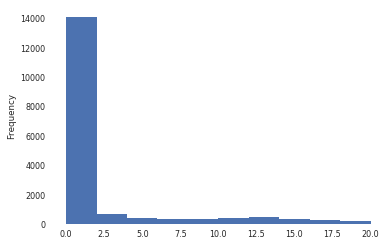

In [8]:
fp.sum(axis=1).plot.hist()

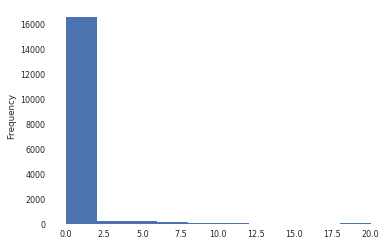

In [9]:
fn.sum(axis=1).plot.hist()

In [10]:
# join with expenditure data
exp_and_fp = fp.join(exp_data)
exp_and_fn = fn.join(exp_data)

In [11]:
# households with at least one false negative model (models are first twenty columns)
has_a_false_neg = exp_and_fn[exp_and_fn.iloc[:, :20].any(axis=1)]

# households with at least one false positive model (models are first twenty columns)
has_a_false_pos = exp_and_fp[exp_and_fp.iloc[:, :20].any(axis=1)]

### All False negatives are actually "Poor" (we predicted "non-poor", which is negative) 

 - `True` for the original boolean provided to us
 - also true if recalculated from expenditure data

In [12]:
exp_and_fn.loc[has_a_false_neg.index].original_poor_bool.value_counts()

True    1299
Name: original_poor_bool, dtype: int64

In [13]:
exp_and_fn.loc[has_a_false_neg.index].expenditure_poor.value_counts()

True    1299
Name: expenditure_poor, dtype: int64

### All False positives are actually "Non-Poor" (we predicted "poor", which is positive) 

 - true for the original boolean provided to us
 - also true if recalculated from expenditure data

In [14]:
exp_and_fp.loc[has_a_false_pos.index].original_poor_bool.value_counts()

False    4413
Name: original_poor_bool, dtype: int64

In [15]:
exp_and_fp.loc[has_a_false_pos.index].expenditure_poor.value_counts()

False    4413
Name: expenditure_poor, dtype: int64

# Plot FP and FN <a class="anchor" id="plotfpfn"></a>

Now we'll make a graph that shows that all of the "false positives" fall above the poverty line. That is, we predicted them to be positive (poor), but this was false and they are actually non-poor.

Likewise, all the "false negatives" fall below the poverty line. That is, we predicted them to be negative (non-poor) but this was false, and they are actually poor.

Futher, we'll see that most misclassifcations are concentrated near the poverty line.

In [16]:
# households with 5 false negative models (first twenty columns)
has_a_false_neg = exp_and_fn[exp_and_fn.iloc[:, :20].sum(axis=1) > 5]

# households with 5 false positive models (first twenty columns)
has_a_false_pos = exp_and_fp[exp_and_fp.iloc[:, :20].sum(axis=1) > 5]

Now create the plot

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

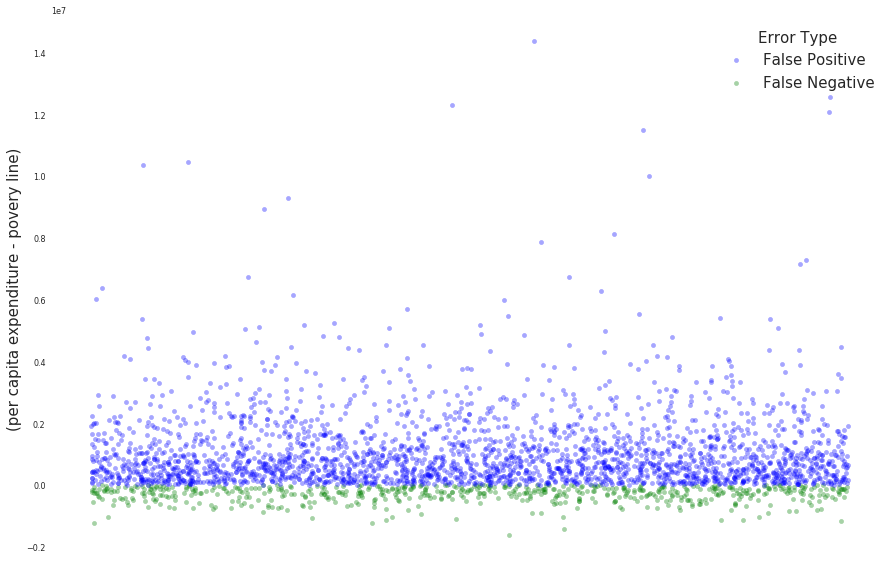

In [17]:
has_a_false_neg['from_pov_line'] = has_a_false_neg.per_capita_expenditure - has_a_false_neg.povline
has_a_false_pos['from_pov_line'] = has_a_false_pos.per_capita_expenditure - has_a_false_pos.povline

has_a_false_neg['jittered'] = np.random.uniform(size=has_a_false_neg.shape[0])
has_a_false_pos['jittered'] = np.random.uniform(size=has_a_false_pos.shape[0])

ax = has_a_false_neg.plot.scatter(x='jittered', y='from_pov_line', c='g', label='False Negative', alpha=0.35, figsize=(15, 10))
has_a_false_pos.plot.scatter(x='jittered', y='from_pov_line', c='b', label='False Positive', alpha=0.35, ax=ax)

ax.set_ylabel("(per capita expenditure - povery line)")
ax.set_xlabel("")


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel(ax.get_xlabel(), fontsize=15)
plt.ylabel(ax.get_ylabel(), fontsize=15)
# plt.setp(ax.legend(bbox_to_anchor=(1, 1), title="Error Type", fontsize=15).get_title(),fontsize=15)
handles, labels = ax.get_legend_handles_labels()
plt.setp(ax.legend(handles[::-1],
                   labels[::-1],
                   title="Error Type",
                   fontsize=15,
                   bbox_to_anchor=(1, 1)).get_title(), fontsize=15);

# Misclassification Confidence <a class="anchor" id="confidence"></a>

Here we'll create a plot that shows the spread of modelconfidences for each error type, grouped by model, and sorted from left to right according to the average median error of the model. Recall that most of the classifiers in this report (and all of the top classifiers) produce probabilities for the two possible class labels.  The probabilities are then rounded to 0 (non-poor) or 1 (poor) to generate a class prediction. This means that there is apossible error range of 0.5: a model that predicts a household labeled “poor” to be “non-poor” (false negative) with probability 0 is the maximum possible distance of 0.5 away from the threshold that would have led to a correct prediction (true positive). Similarly, a model that predicts a household labeled “Non-Poor” to be “Poor” (false positive) is the maximum possible distance of 0.5 away fromthe threshold that would have led to a correct prediction (true negative).

To create the plot, we'll use the false positive and false negative DataFrames, as well as the DataFrame with all predicted probabilites.

In [18]:
# set index back to int
fp.index = fp.index.astype(int)
fn.index = fn.index.astype(int)

# load all predicted probabilies
all_probs = pd.read_csv(Path(ERRORS_DIR, 'all_probs_top_20_models.csv'), index_col='hid')

Get model names 

In [19]:
model_names = fp.drop('y_test', axis=1).columns

In order to plot these models together, we need to change the orientation of the data. We'll use the `melt` function in pandas to create the data format we need for our plots.

In [20]:
melt_fp = pd.melt(fp.reset_index(), id_vars=['hid'], value_vars=model_names, var_name='Model', value_name='Error Type')
melt_fp = melt_fp[melt_fp['Error Type'] != False]
melt_fp['Error Type'] = 'False Positive'

melt_fn = pd.melt(fn.reset_index(), id_vars=['hid'], value_vars=model_names, var_name='Model', value_name='Error Type')
melt_fn = melt_fn[melt_fn['Error Type'] != False]
melt_fn['Error Type'] = 'False Negative'

melt_conf = pd.melt(all_probs.reset_index(), id_vars=['hid'], value_vars=model_names, var_name='Model', value_name='Error')
melt_conf['Error'] = melt_conf['Error'].map(lambda x: 1 - x if x > 0.5 else x)

melt_errs = pd.concat((melt_fp, melt_fn))
melt_conf = melt_conf.loc[melt_errs.index]

melted = melt_errs.merge(melt_conf, on=['hid', 'Model'])
melted.sample(10)

,hid,Model,Error Type,Error
38096,6409010200190306,lda_full,False Negative,0.231395
180,1214080201130305,deepfm_full_cv,False Positive,0.247584
648,7503031200310308,lr_full,False Positive,0.088317
21288,1704030250010401,lr_full_classwts,False Positive,0.215686
32896,3209150254420801,rf_feats,False Positive,0.437791
4165,1507030250150110,ensemble_simple,False Positive,0.412391
31555,7402080200260409,rf_feats,False Positive,0.474049
27711,8103051250240205,xgb_feats,False Positive,0.085970
42659,1306090200370106,rf_full_oversample,False Negative,0.208748
33399,3273180158670304,rf_feats,False Positive,0.419605


In [21]:
ordered_by_median = melted.groupby('Model')['Error'].median().sort_values().index.values

Create plot

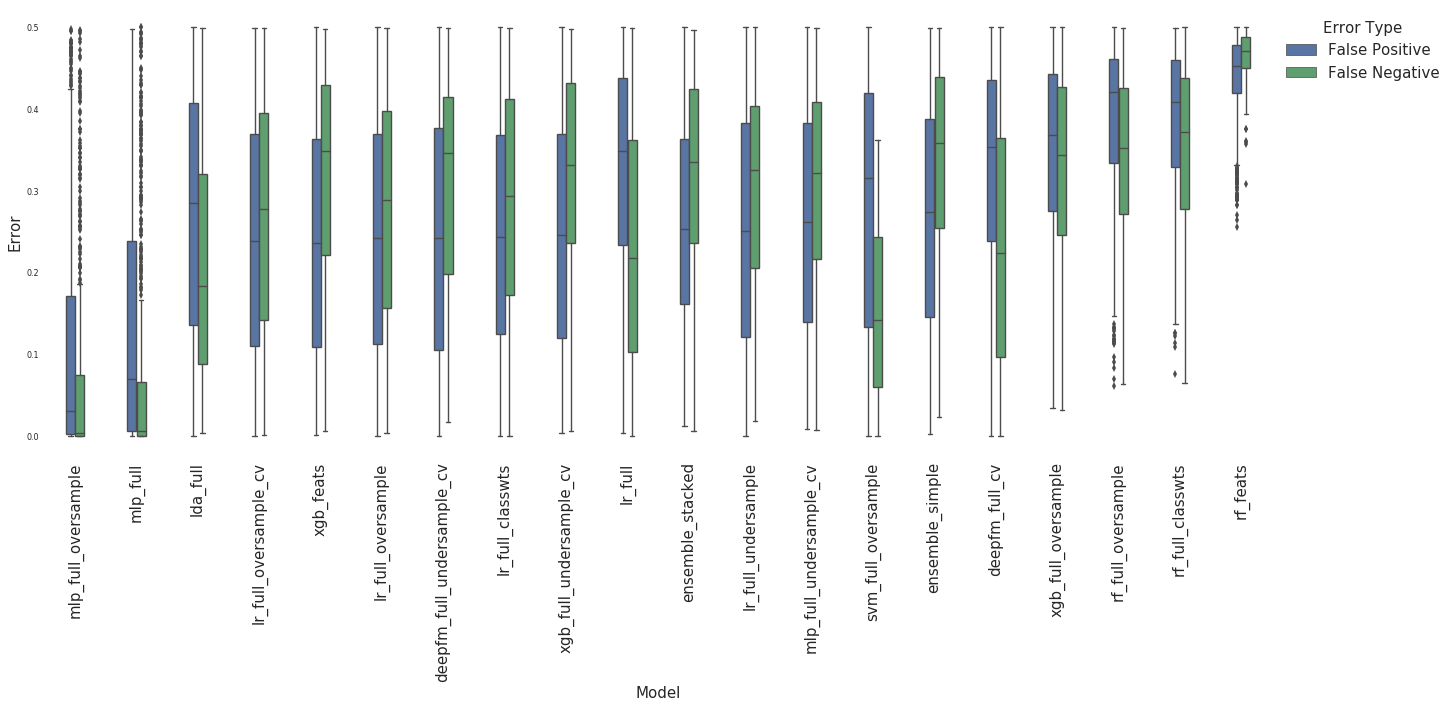

In [22]:
fig, ax = plt.subplots()

fig.set_size_inches(22, 8.27)

sns.boxplot(x='Model', y='Error', hue='Error Type', data=melted, ax=ax, width=0.3, order=ordered_by_median)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=15)
plt.xlabel(ax.get_xlabel(), fontsize=15)
plt.ylabel(ax.get_ylabel(), fontsize=15)
plt.setp(ax.legend(bbox_to_anchor=(1, 1), title="Error Type", fontsize=15).get_title(),fontsize=15);

 A tighter box indicates less variability in model confidence, so for example the “svm_full_classwts” model consistently almost correctly predicted its false negative households, because the false negative box (green) is close to 0 error and has a maximum error of less than 0.1.  The same model’s false positive box (blue) however, has much more variability, with minimum errors close to 0 and maximum errors at the global maximum of 0.5. In this sense, the spread of a box in these plots can be taken to correspond to model consistency. Additionally, note that the “deepfm_full_cv,” which is one of the overall top performing models, consistently makes almost the maximum possible error in its false positive (blue) predictions, indicating a high but incorrect model confidence.

# Plot Consumption Rate <a class="anchor" id="consrate"></a>

The following DataFrames are indexed by household, with the first $N$ columns labeled by model (disregard the remaining columns, which contain additional information such as the ground truth label, distance from the poverty line, and more). Each entry in these first $N$ columns is boolean.

**`exp_and_fn`:** Entry $(i,j)$ is `True` if household $i$ is poor but was classified as non-poor (false negative). The entry is `False` otherwise.

**`exp_and_fp`:** Entry $(i,j)$ is `True` if household $i$ is non-poor but was classified as poor (false positive). The entry is `False` otherwise.



In [23]:
exp_and_fn.iloc[:, :20].sample(10)

,deepfm_full_cv,lr_full,mlp_full_undersample_cv,ensemble_simple,lr_full_oversample,xgb_full_undersample_cv,lr_full_oversample_cv,ensemble_stacked,lr_full_undersample,lda_full,rf_full_classwts,svm_full_oversample,lr_full_classwts,deepfm_full_undersample_cv,mlp_full,xgb_feats,xgb_full_oversample,mlp_full_oversample,rf_feats,rf_full_oversample
hid,,,,,,,,,,,,,,,,,,,,
9435050200110201,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1373040200010608,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7501052200610510,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3601181251140509,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1708040200250308,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1408010250030207,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3671051154730602,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3512100250850205,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8207050200010106,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [24]:
exp_and_fp.iloc[:, :20].sample(10)

,deepfm_full_cv,lr_full,mlp_full_undersample_cv,ensemble_simple,lr_full_oversample,xgb_full_undersample_cv,lr_full_oversample_cv,ensemble_stacked,lr_full_undersample,lda_full,rf_full_classwts,svm_full_oversample,lr_full_classwts,deepfm_full_undersample_cv,mlp_full,xgb_feats,xgb_full_oversample,mlp_full_oversample,rf_feats,rf_full_oversample
hid,,,,,,,,,,,,,,,,,,,,
1207130200020502,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1225060200090302,True,True,True,True,True,True,True,True,True,True,False,True,True,True,False,True,True,True,True,True
7313080250080110,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3672030151400401,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5108060200970206,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1221080200850206,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3312100202810505,False,False,True,True,True,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True
8203063200220209,False,False,True,True,False,True,False,True,True,False,True,True,False,True,False,True,True,False,True,True
6211062200070105,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


To simplify our description of misclassifications, we say that a given household *has* a false positive (negative) model if at least 5 models have misclassified the household in that way (type 1 error i.e., false positive, or type 2 error i.e., false negative).

In [25]:
N = 5

# households with at least 5 false negative model (first twenty columns)
has_a_false_neg = exp_and_fn.iloc[:, :20].sum(axis=1) >= N
has_a_false_neg_idx = has_a_false_neg[has_a_false_neg == True].index
num_false_neg = exp_and_fn.loc[has_a_false_neg].iloc[:, :20].sum(axis=1)

# households with at least 5 false positive model (first twenty columns)
has_a_false_pos = exp_and_fp.iloc[:, :20].sum(axis=1) >= N
has_a_false_pos_idx = has_a_false_pos[has_a_false_pos == True].index
num_false_pos = exp_and_fp.loc[has_a_false_pos].iloc[:, :20].sum(axis=1)

In [26]:
has_a_false_neg_idx.isin(has_a_false_pos_idx).sum()

0

In [27]:
has_a_false_pos_idx.isin(has_a_false_neg_idx).sum()

0

It is an interesting result that there are no houses with at least 5 false positive models and also 5 false negative models. This seems to suggest that whatever is causing misclassification is unlikely due to model parameters and more likely due to specific properties of those households.

Now we will look at comparing the rate of consumption and variable occurrence across four populations: correctly classified poor (true positives), incorrectly classified as poor (false positives), correctly classified as nonpoor (true negatives), and incorrectly classified as nonpoor (false negatives).

To do these calculations, we'll convert all our features variables that are not already binary into binary features.

In [28]:
# convert original survey index to string
idn_hhold.index = idn_hhold.index.astype(str)

# find consumption variables (already dummies) and hld vars (not necc dummies) and convert all to dummy
hld_vars = [c for c in idn_hhold.columns if c.startswith('hld') and not 'nbcell' in c]

hld_dummies = pd.get_dummies(idn_hhold[hld_vars], drop_first=False, dummy_na=True)

# convert integer 1/0 dummies to boolean True False
hld_dummies = hld_dummies.astype(bool)

In [29]:
# drop old hld vars
idn_hhold = idn_hhold.drop(labels=hld_vars, axis=1)

# join new dummy versions of hld vars
idn_hhold = idn_hhold.join(hld_dummies)

idn_hhold.shape

(70843, 503)

In [30]:
# convert `cons` variables that are "Yes" / "No" into booleans
cons_vars = [c for c in idn_hhold.columns if c.startswith('cons')]
hld_vars = [c for c in idn_hhold.columns if c.startswith('hld')  and not 'nbcell' in c]

idn_hhold.loc[:, cons_vars] = idn_hhold.loc[:, cons_vars] == 'Yes'

Next we'll calculate the "consumption rates" (that is, what percentage of households say "Yes" to a particular question) for both the "poor" households and the "non-poor" households.

In [31]:
# use binary versions of both `hld` properties and consumption variables
columns_of_interest = cons_vars + hld_vars

poor_mask = idn_hhold.poor == 'Poor'
cons_rt_poor = idn_hhold[columns_of_interest][poor_mask].mean(axis=1).rename('Cons Rate (Poor)')

In [32]:
nonpoor_mask = idn_hhold.poor != 'Poor'
cons_rt_nonpoor = idn_hhold[columns_of_interest][nonpoor_mask].mean(axis=1).rename('Cons Rate (Non-Poor)')

### Define Plotting Function

Now we will create a function that takes household indices, e.g. those corresponding to households with at least $N$ false positive/negative models, where we have set $N$ to 5 above.

The consumption rate of any categorical survey question is determined by taking the normalized value count of affirmative answers, e.g. “X%of households answered “Yes” to owning a refrigerator.” For the plots below, we will compare the consumption behavior of misclassified exampled to both `Poor` and `Non-Poor` consumption behaviors of the aggregated population. For each type of misclassification, false positives (predicted `Poor`, labeled `Non-Poor`) and false negatives (predicted `Non-Poor`, labeled `Poor`), we will

* compute the sample's consumption rates
* subtract from the sample rate the "baseline" rates for `Poor` households and plot the result as a horizontal bar chart
* subtract from the sample rate the "baseline" rates for `Non-Poor` households and plot the result as a horizontal bar chart

In these plots, a positive value indicates that the sample's consumption rate is smaller than the baseline (two separate plots are created for each sample, one with `Poor` as a baseline and one with `Non-Poor` as a baseline).

In [33]:
def poor_nonpoor_plot(population_df, subset_idx, group_name, top_N=20):
    rates_poor = population_df[population_df.poor == 'Poor'].mean()    
    rates_non_poor = population_df[population_df.poor != 'Poor'].mean()
    
    rates_subset = population_df.loc[subset_idx, :].mean()
    
    diff_poor = rates_subset - rates_poor
    diff_non_poor = rates_subset - rates_non_poor
    
    poor_vars = (diff_poor.abs() > 0)
    non_poor_vars = (diff_non_poor.abs() > 0)
    
    to_plot_poor = diff_poor[poor_vars]
    to_plot_non_poor = diff_non_poor[non_poor_vars]
    
    magnitude_poor = to_plot_poor.abs().sort_values(ascending=False)
    magnitude_non_poor = to_plot_non_poor.abs().sort_values(ascending=False)
    
    def _get_label(var):
        if var.startswith('cons'):
            return idn_hhold_questions[var]
        else:
            question, value = var.rsplit('_', 1)
        return f'{idn_hhold_questions[question]}: {value.title()}'

    fontsize = 12
    poor_xlabel = 'Consume At Lower Rate Than Poor (-)  /  Consume At Higher Rate than Poor (+)'
    non_poor_xlabel = 'Consume At Lower Rate Than Non-Poor (-)  /  Consume At Higher Rate than Non-Poor (+)'
    kwargs = dict(figsize=(8, int(top_N / 3)), fontsize=fontsize)
    
    cols_to_rename = population_df.drop('poor', axis=1).columns
    ax1 = (to_plot_poor[magnitude_poor.head(top_N).index]
                       .rename(index={var: _get_label(var) for var in cols_to_rename})
                       .plot
                       .barh(color='#3e78bc', **kwargs))
    LIM = 0.5
    ax1.set_xlabel(poor_xlabel, fontsize=fontsize)
    ax1.set_xlim([-LIM, LIM])
    ax1.set_title(f'{group_name} Compared to Poor Households (top {top_N} by magnitude)', fontsize=fontsize + 6)
    plt.show()
    
    ax2 = (to_plot_non_poor[magnitude_non_poor.head(top_N).index]
                           .rename(index={var: _get_label(var) for var in cols_to_rename})
                           .plot
                           .barh(color='#bc3e3e', **kwargs))
    ax2.set_xlabel(non_poor_xlabel, fontsize=fontsize)
    ax2.set_xlim([-LIM, LIM])
    ax2.set_title(f'{group_name} Compared to Non-Poor Households (top {top_N} by magnitude)', fontsize=fontsize + 6)
    
    

## Consumption Behavior of False Positives 

Use the false positive indices calculated above to build the plot.

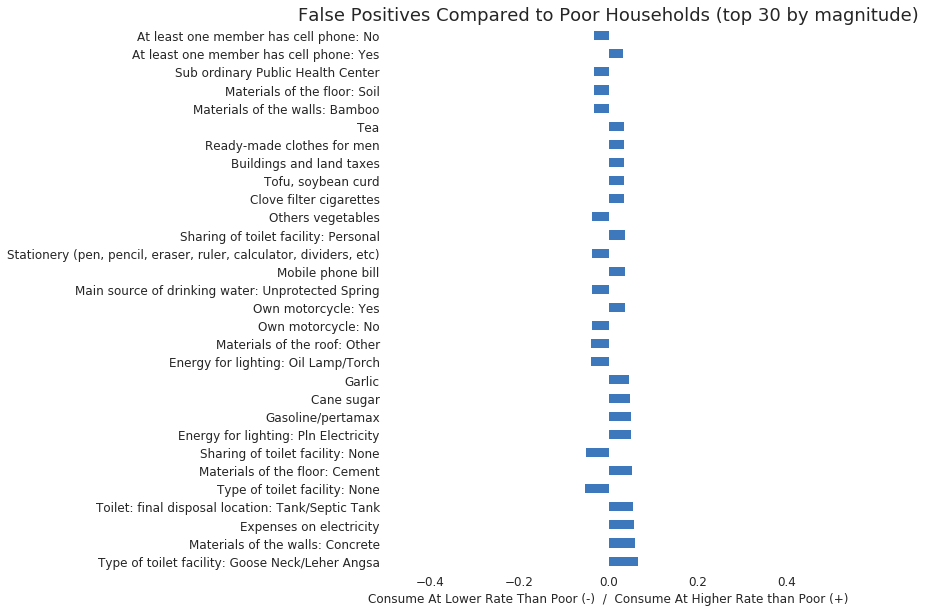

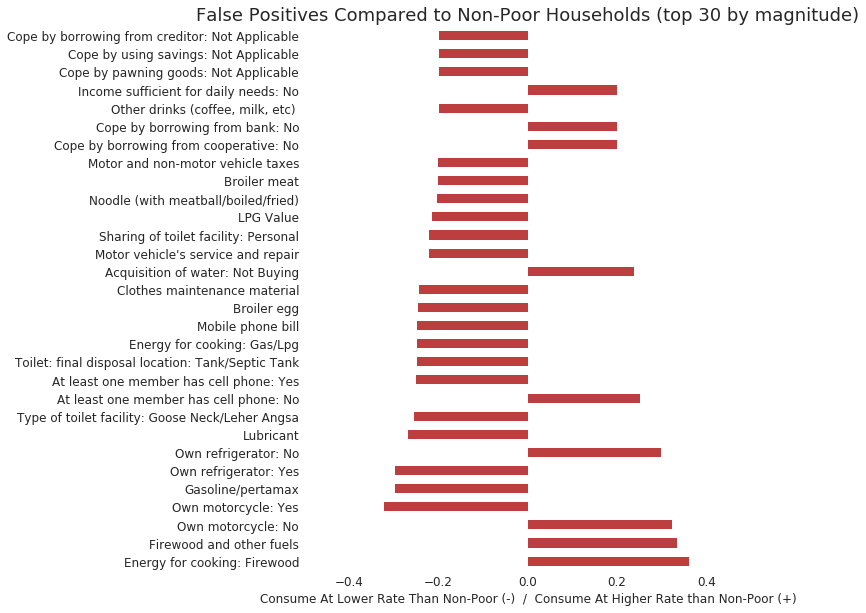

In [34]:
poor_nonpoor_plot(idn_hhold[columns_of_interest + ['poor']],
                  has_a_false_pos_idx,
                  group_name='False Positives',
                  top_N=30)

The false positives (predicted poor, labeled non-poor) exhibit consumption patterns more similar to the poor population.

## Consumption behavior of False Negatives

Use the false negative indices calculated above to build the plot.

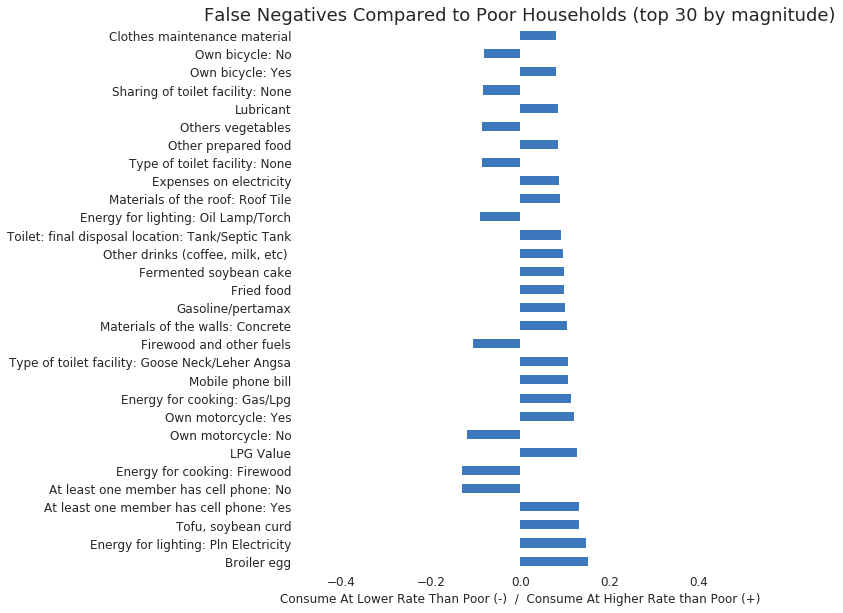

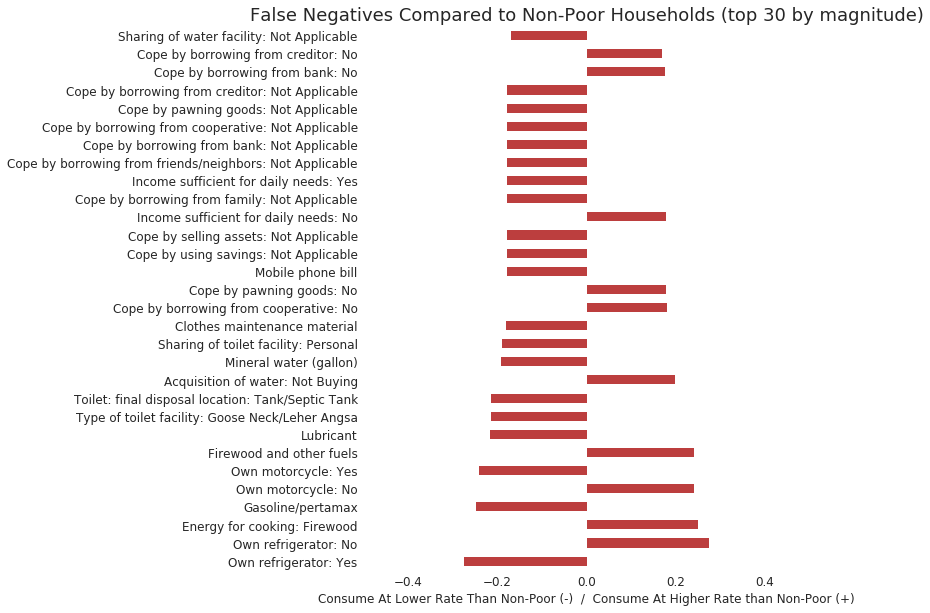

In [35]:
poor_nonpoor_plot(idn_hhold[columns_of_interest + ['poor']],
                  has_a_false_neg_idx,
                  group_name='False Negatives',
                  top_N=30)

The false negatives (predicted non-poor, labeled poor) also exhibit consumption patterns more similar to the poor population. They do seem to be slightly less like the poor population and slightly moor like the non-poor households than the false positives were, and this difference is likely what some of the models which misclassified these households identified.

# Summary <a class="anchor" id="summary"></a>

All the models studied in this project made some misclassifications. When the feature structure of these misclassified features is considered, it appears that the samples are more similar to poor households (relative to the rest of the dataset).